In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Activation, UpSampling2D, Dropout, BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import activations, Sequential
import graphviz

2024-01-06 17:05:34.513100: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 17:05:34.544646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 17:05:34.544674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 17:05:34.545550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 17:05:34.550392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 17:05:34.550732: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
LAMBDA = 100

In [3]:
class Generator:
    
    def __init__(self, shape_of_image) :
        self.input_layer = Input(shape=shape_of_image)
        self.previous_layer = self.input_layer
        
        # downsampling
        d1 = self.downsample(64, 4)
        d2 = self.downsample(128, 4) 
        d3 = self.downsample(256, 4) 
        d4 = self.downsample(512, 4) 
        d5 = self.downsample(512, 4) 
        d6 = self.downsample(512, 4) 
        d7 = self.downsample(512, 4) 
        d8 = self.downsample(512, 4) 
        
        # upsampling
        self.upsample(512, 4, d7,  dropout_rate=0.5) 
        self.upsample(512, 4, d6,  dropout_rate=0.5) 
        self.upsample(512, 4, d5,  dropout_rate=0.5) 
        self.upsample(512, 4, d4) 
        self.upsample(256, 4, d3) 
        self.upsample(128, 4, d2) 
        self.upsample(64,  4, d1) 
        
        self.output_layer = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(self.previous_layer)
        self.model = keras.Model(inputs=self.input_layer, outputs=self.output_layer, name="Generator(U-Net)")
        
    
    def downsample(self, filters, kernel_size):
        sequential = Sequential()
        initializer = tf.random_normal_initializer(0., 0.02)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer=initializer)
        sequential.add(conv)
        norm = BatchNormalization()
        sequential.add(norm)
        relu = Activation(activations.relu)
        sequential.add(relu)
        self.previous_layer = sequential(self.previous_layer)
        return self.previous_layer
    
    def upsample(self, filters, kernel_size, skip_layer=None, dropout_rate=0.0):
        initializer = tf.random_normal_initializer(0., 0.02)
        sequential = Sequential()
        conv_transpose = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, padding='same', kernel_initializer=initializer)
        sequential.add(conv_transpose)
        norm = BatchNormalization()
        sequential.add(norm)
        if (dropout_rate > 0) :
            dropout = Dropout(dropout_rate)
            sequential.add(dropout)
            
        relu = Activation(activations.relu)
        sequential.add(relu)
        self.previous_layer = sequential(self.previous_layer)
        if skip_layer is not None:
            self.previous_layer = tf.keras.layers.Concatenate()([self.previous_layer, skip_layer])

    def generator_loss(self, discriminator_output, generator_output, target): 
        # generator_loss = cross_entropy_loss + LAMBDA * L1_loss
        
        binary_cross_entropy = BinaryCrossentropy(from_logits=True)
        # cross-entropy loss -> discriminator(generated image) & 1
        cross_entropy_loss = binary_cross_entropy(tf.ones_like(discriminator_output), discriminator_output)

        # mean absolute error -> original_image & generated image
        l1_loss = tf.reduse_mean(tf.abs(target - generator_output))

        generator_loss = cross_entropy_loss + (LAMBDA * l1_loss)
        return generator_loss, cross_entropy_loss, l1_loss

In [4]:
generator = Generator((256, 256, 3)).model

2024-01-06 17:05:39.057910: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [5]:
generator.summary()

Model: "Generator(U-Net)"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3392      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131712    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525568    ['sequential_1[0][0]']        
                                                                                   

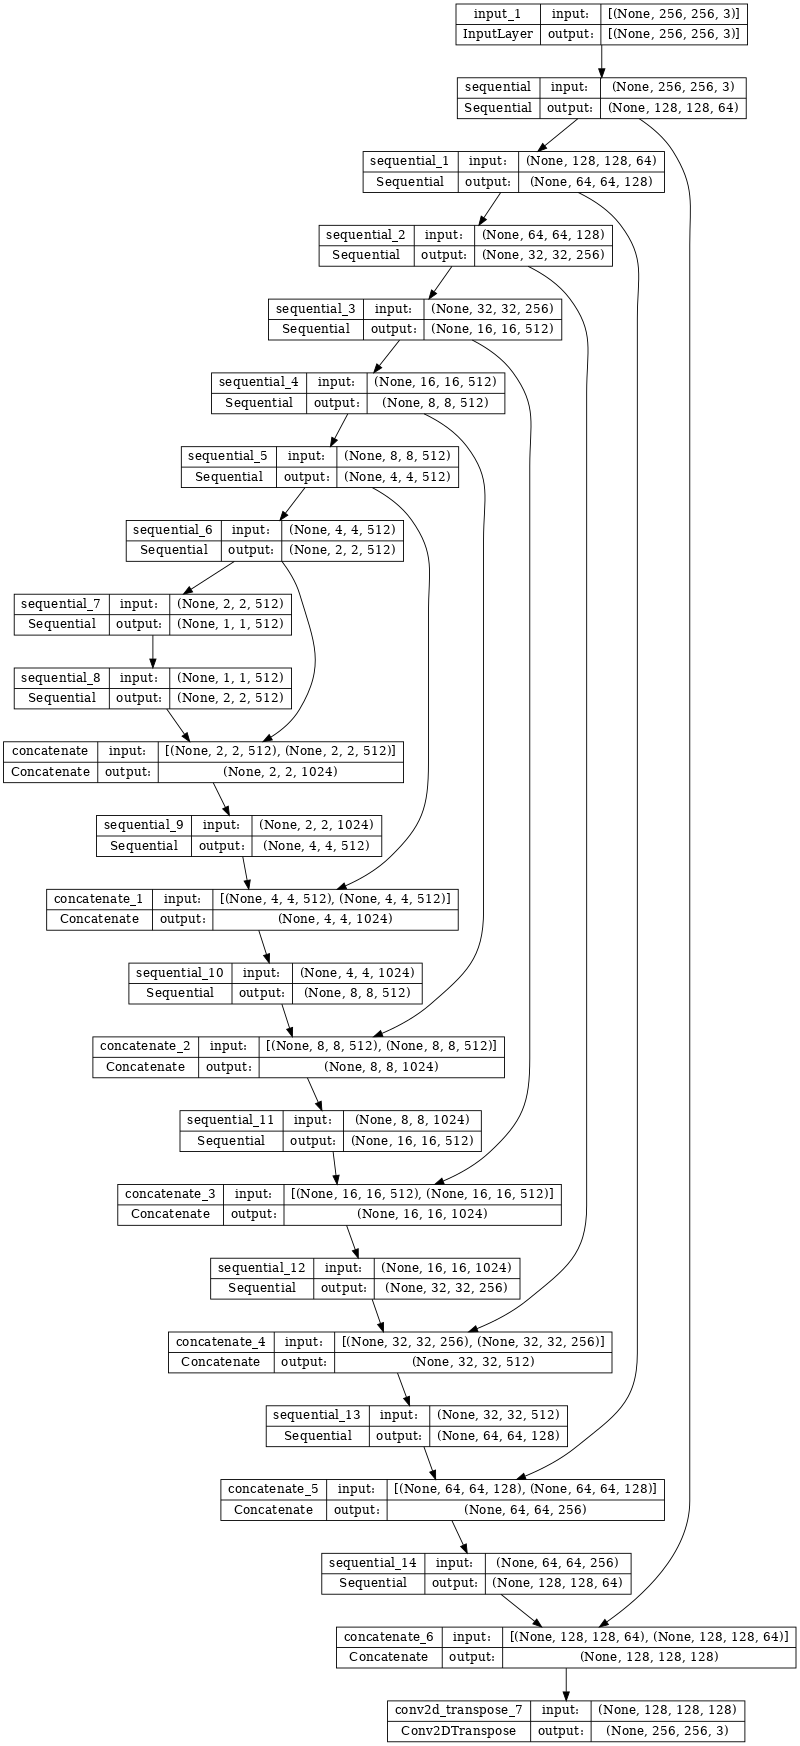

In [6]:
keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='../images/generatorModel.png')